# 주식 예측
- 삼성 : 005930
- 네이버 : 035420
- 카카오 : 035720

In [337]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error

import os
import math

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

<br><br><br><br>

# 삼성

## 1. 시계열 데이터 준비
- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
- date와 close(종가)컬럼만 사용

In [42]:
# samsung - Time Series 생성
samsung_dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
samsung_df = pd.read_csv(samsung_dataset_filepath, index_col='Date', parse_dates=True)
samsung_ts = samsung_df['Close']
samsung_ts.head()

Date
2000-01-04    6110.0
2000-01-05    5580.0
2000-01-06    5620.0
2000-01-07    5540.0
2000-01-10    5770.0
Name: Close, dtype: float64

## 2. 데이터 전처리
### 2-1. 결측치 처리

In [45]:
# samsung
print(samsung_ts[samsung_ts.isna()])

samsung_ts = samsung_ts.interpolate(method='time')
samsung_ts[samsung_ts.isna()]

Date
2005-01-03   NaN
2017-11-16   NaN
2017-11-23   NaN
2018-01-02   NaN
2018-11-15   NaN
2019-11-14   NaN
Name: Close, dtype: float64


Series([], Name: Close, dtype: float64)

### 2-2. 로그 변환

In [140]:
samsung_ts_log = np.log(samsung_ts)

## 3. 시계열 안정성 분석
### 3-1. 정성적 그래프 분석

In [142]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

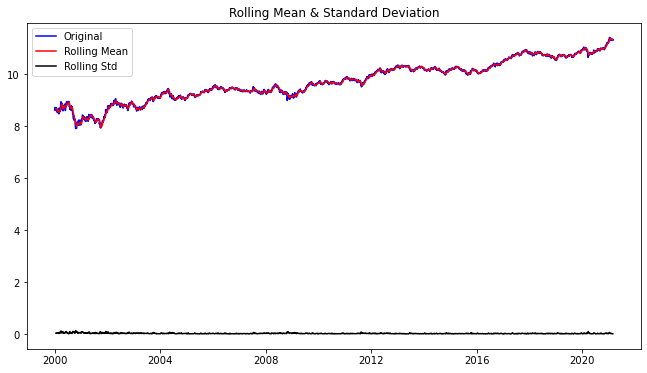

In [50]:
plot_rolling_statistics(samsung_ts_log, window=12)

### 3-2. ADF Test

In [53]:
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [54]:
augmented_dickey_fuller_test(samsung_ts_log)

Results of Dickey-Fuller Test:
Test Statistic                   -0.325391
p-value                           0.921830
#Lags Used                        4.000000
Number of Observations Used    5313.000000
Critical Value (1%)              -3.431581
Critical Value (5%)              -2.862084
Critical Value (10%)             -2.567060
dtype: float64


### 3-3. 시계열 분해 Time Series Decomposition

In [16]:
def time_series_decomposition(ts_log):
    decomposition = seasonal_decompose(ts_log, model='multiplicative', period=30)

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.rcParams["figure.figsize"] = (11,6)
    
    plt.subplot(411)
    plt.plot(ts_log, label='original')
    plt.legend(loc='best')

    plt.subplot(412)
    plt.plot(trend, label='trend')
    plt.legend(loc='best')

    plt.subplot(413)
    plt.plot(seasonal, label='seosonality')
    plt.legend(loc='best')

    plt.subplot(414)
    plt.plot(residual, label='residual')
    plt.legend(loc='best')

    plt.tight_layout()
    
    # Residual 안정성 확인
    residual.dropna(inplace=True)
    augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.759298e+01
p-value                        3.955529e-30
#Lags Used                     3.300000e+01
Number of Observations Used    5.254000e+03
Critical Value (1%)           -3.431595e+00
Critical Value (5%)           -2.862090e+00
Critical Value (10%)          -2.567063e+00
dtype: float64


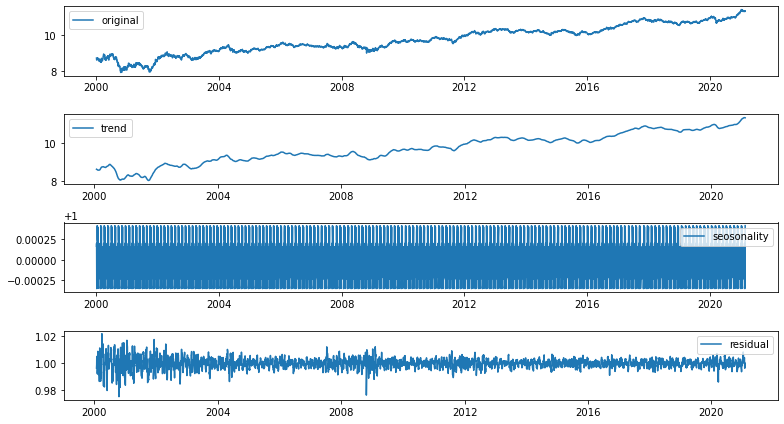

In [57]:
time_series_decomposition(samsung_ts_log)

## 4. train, test dataset 생성

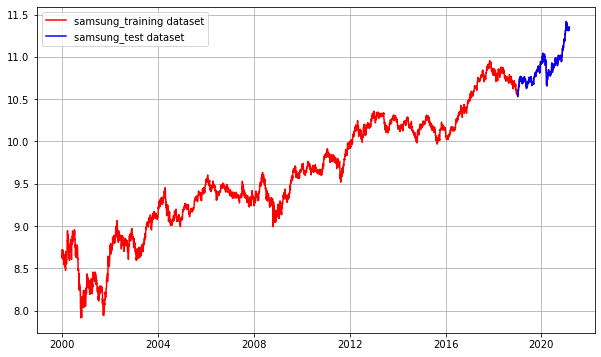

In [60]:
samsung_train_data, samsung_test_data = samsung_ts_log[:int(len(samsung_ts_log)*0.9)], samsung_ts_log[int(len(samsung_ts_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(samsung_ts_log, c='r', label='samsung_training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(samsung_test_data, c='b', label='samsung_test dataset')
plt.legend()

## 5. 적정 ARIMA 모수 찾기
- q : ACF를 통해 MA모델의 시차 q를 결정
- p : PACF를 통해 AR 모델의 시차 p를 결정
- d : 차분

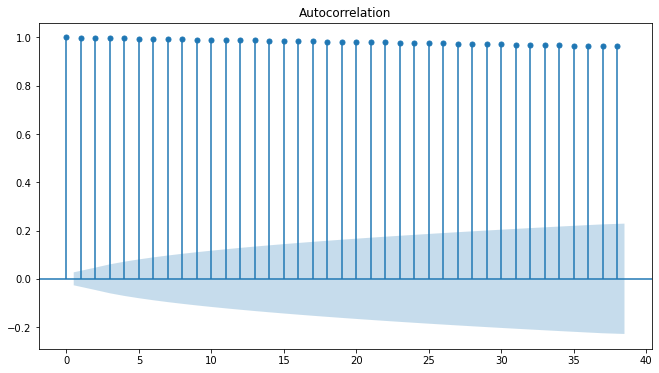

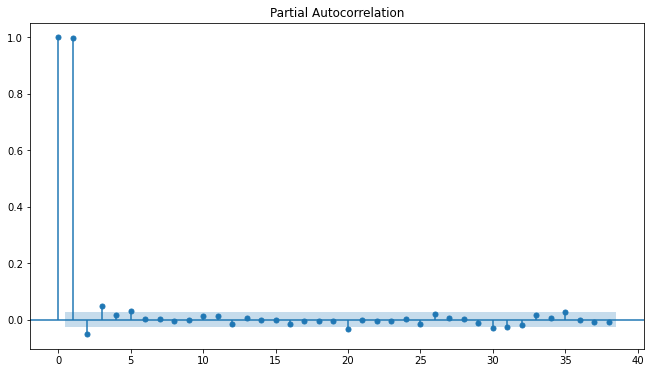

In [19]:
plot_acf(samsung_ts_log)
plot_pacf(samsung_ts_log)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -40.102097
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    5313.000000
Critical Value (1%)              -3.431581
Critical Value (5%)              -2.862084
Critical Value (10%)             -2.567060
dtype: float64


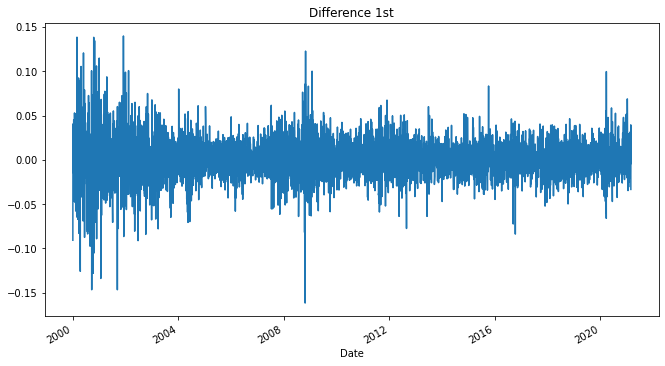

In [20]:
# 차분 안정성 확인 -> d구하기
samsung_diff_1 = samsung_ts_log.diff(periods=1).iloc[1:]
samsung_diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(samsung_diff_1)

In [ ]:
# 2차 차분 구하기
samsung_diff_2 = samsung_diff_1.diff(periods=1).iloc[1:]
samsung_diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(samsung_diff_2)

- q = 0
- p = 1
- d = 1

## 6. ARIMA 모델 훈련과 테스트

In [67]:
def arima_test(train_data, test_data, order):
    # arima(data, order=c(p,d,q))
    model = ARIMA(train_data, order=order)
    fitted_m = model.fit(disp=-1)
    print(fitted_m.summary())
    
    # Forecast : 결과가 fc에 담깁니다. 
    fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

    # Make as pandas series
    fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
    lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
    upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

    # Plot
    plt.figure(figsize=(9,5), dpi=100)
    plt.plot(train_data, label='training')
    plt.plot(test_data, c='b', label='actual price')
    plt.plot(fc_series, c='r',label='predicted price')
    plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
    plt.legend()
    plt.show()
    
    mse = mean_squared_error(np.exp(test_data), np.exp(fc))
    print('MSE: ', mse)

    mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
    print('MAE: ', mae)

    rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
    print('RMSE: ', rmse)

    mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
    print('MAPE: {:.2f}%'.format(mape*100))

/home/ssac14/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/ssac14/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4785
Model:                 ARIMA(1, 1, 0)   Log Likelihood               11277.411
Method:                       css-mle   S.D. of innovations              0.023
Date:                Sun, 28 Feb 2021   AIC                         -22548.823
Time:                        23:47:55   BIC                         -22529.403
Sample:                             1   HQIC                        -22542.001
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0004      0.000      1.111      0.266      -0.000       0.001
ar.L1.D.Close     0.0437      0.014      3.018      0.003       0.015       0.072
                                    Root

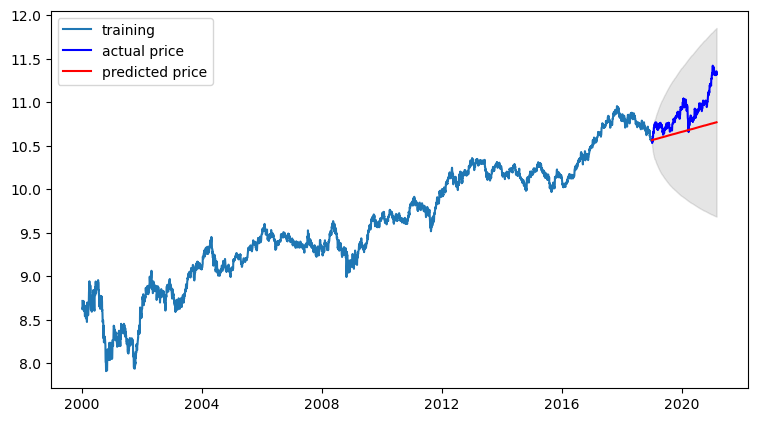

MSE:  214746746.26469508
MAE:  11296.362313772373
RMSE:  14654.239873316359
MAPE: 18.68%


In [138]:
arima_test(samsung_train_data, samsung_test_data, (1, 1, 0))

# 삼성 2

## 1. 시계열 데이터 준비

In [338]:
# samsung - Time Series 생성
samsung_dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930_5y.KS.csv'
samsung_df = pd.read_csv(samsung_dataset_filepath, index_col='Date', parse_dates=True)
samsung_ts = samsung_df['Close']
samsung_ts.head()

Date
2016-03-02    23940.0
2016-03-03    24400.0
2016-03-04    24300.0
2016-03-07    24460.0
2016-03-08    23840.0
Name: Close, dtype: float64

## 2. 데이터 전처리
### 2-1. 결측치 처리

In [339]:
# samsung
print(samsung_ts[samsung_ts.isna()])

samsung_ts = samsung_ts.interpolate(method='time')
samsung_ts[samsung_ts.isna()]

Date
2017-11-16   NaN
2017-11-23   NaN
2018-01-02   NaN
2018-11-15   NaN
2019-11-14   NaN
Name: Close, dtype: float64


Series([], Name: Close, dtype: float64)

### 2-2. 로그 변환

In [340]:
samsung_ts_log = np.log(samsung_ts)

## 3. 시계열 안정성 분석
### 3-1. 정성적 그래프 분석

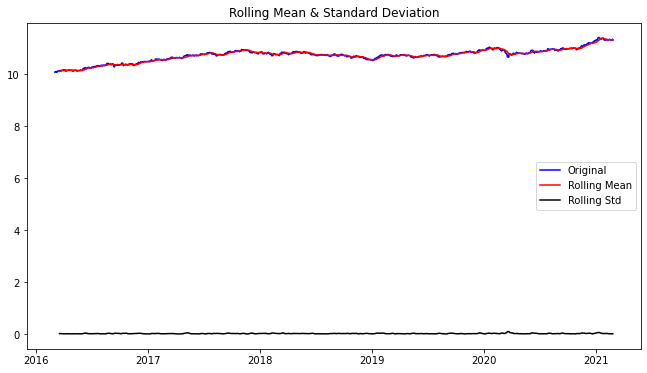

In [342]:
plot_rolling_statistics(samsung_ts_log, window=12)

### 3-2. ADF Test

In [344]:
augmented_dickey_fuller_test(samsung_ts_log)

Results of Dickey-Fuller Test:
Test Statistic                   -1.405147
p-value                           0.579806
#Lags Used                        0.000000
Number of Observations Used    1224.000000
Critical Value (1%)              -3.435704
Critical Value (5%)              -2.863904
Critical Value (10%)             -2.568029
dtype: float64


### 3-3. 시계열 분해 Time Series Decomposition

Results of Dickey-Fuller Test:
Test Statistic                -1.016998e+01
p-value                        7.131720e-18
#Lags Used                     2.000000e+01
Number of Observations Used    1.174000e+03
Critical Value (1%)           -3.435932e+00
Critical Value (5%)           -2.864005e+00
Critical Value (10%)          -2.568082e+00
dtype: float64


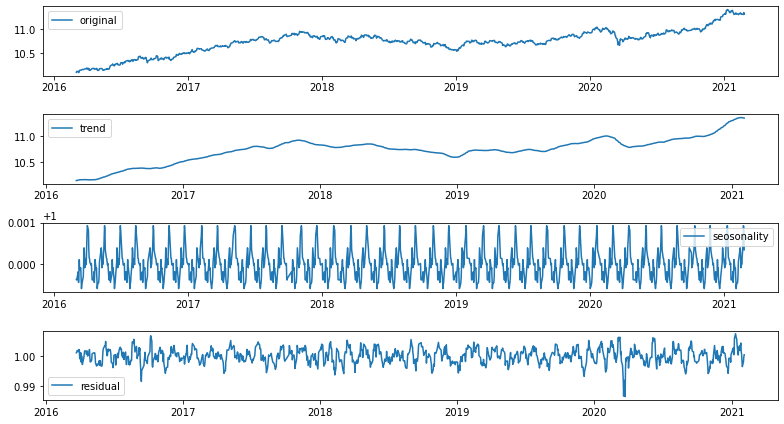

In [346]:
time_series_decomposition(samsung_ts_log)

## 4. train, test dataset 생성

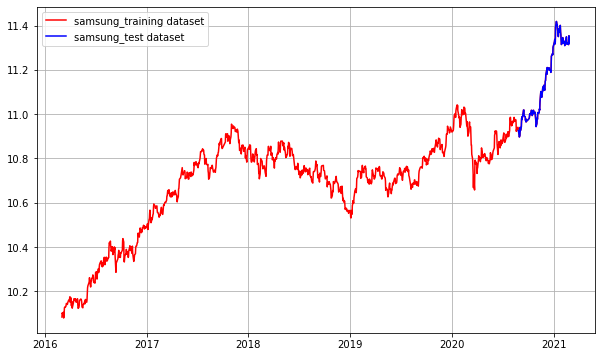

In [347]:
samsung_train_data, samsung_test_data = samsung_ts_log[:int(len(samsung_ts_log)*0.9)], samsung_ts_log[int(len(samsung_ts_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(samsung_ts_log, c='r', label='samsung_training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(samsung_test_data, c='b', label='samsung_test dataset')
plt.legend()

## 5. 적정 ARIMA 모수 찾기
- q : ACF를 통해 MA모델의 시차 q를 결정
- p : PACF를 통해 AR 모델의 시차 p를 결정
- d : 차분

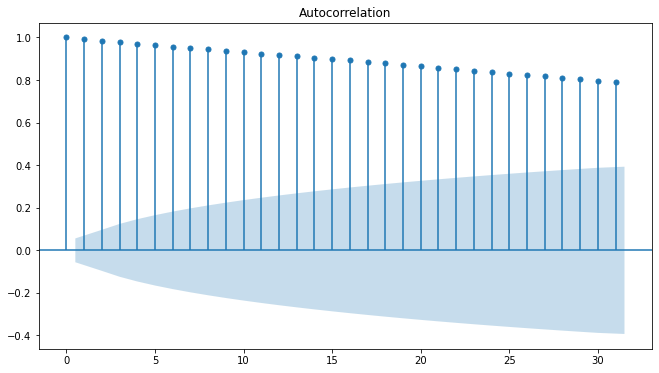

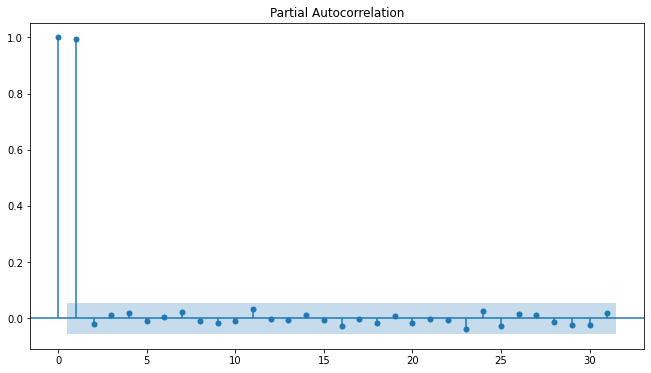

In [348]:
plot_acf(samsung_ts_log)
plot_pacf(samsung_ts_log)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -34.235840
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1223.000000
Critical Value (1%)              -3.435708
Critical Value (5%)              -2.863906
Critical Value (10%)             -2.568030
dtype: float64


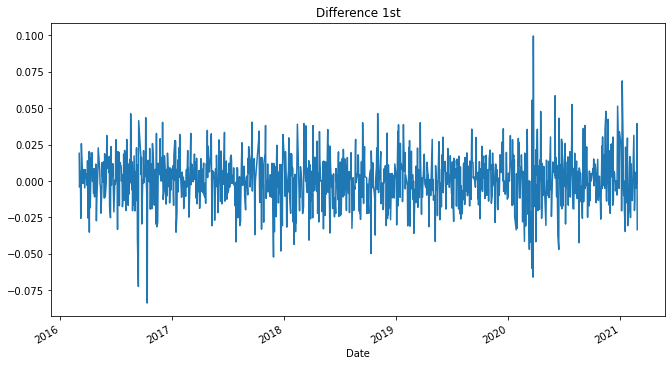

In [349]:
# 차분 안정성 확인 -> d구하기
samsung_diff_1 = samsung_ts_log.diff(periods=1).iloc[1:]
samsung_diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(samsung_diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.286772e+01
p-value                        4.954192e-24
#Lags Used                     2.100000e+01
Number of Observations Used    1.201000e+03
Critical Value (1%)           -3.435807e+00
Critical Value (5%)           -2.863950e+00
Critical Value (10%)          -2.568053e+00
dtype: float64


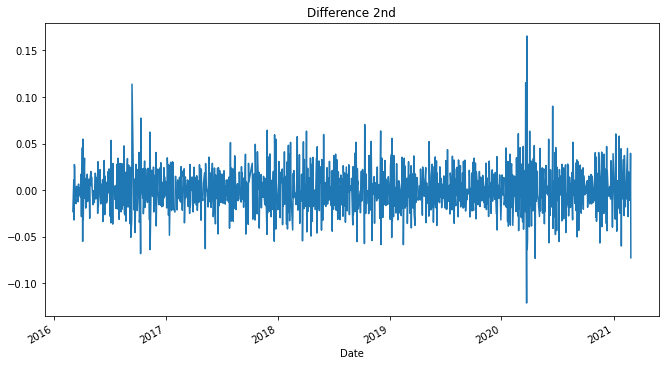

In [350]:
# 2차 차분 구하기
samsung_diff_2 = samsung_diff_1.diff(periods=1).iloc[1:]
samsung_diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(samsung_diff_2)

- q = 0
- p = 1
- d = 1

## 6. ARIMA 모델 훈련과 테스트

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1101
Model:                 ARIMA(1, 1, 0)   Log Likelihood                2920.362
Method:                       css-mle   S.D. of innovations              0.017
Date:                Mon, 01 Mar 2021   AIC                          -5834.724
Time:                        04:08:44   BIC                          -5819.712
Sample:                             1   HQIC                         -5829.045
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0008      0.001      1.492      0.136      -0.000       0.002
ar.L1.D.Close     0.0153      0.030      0.509      0.611      -0.044       0.074
                                    Root

/home/ssac14/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/ssac14/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


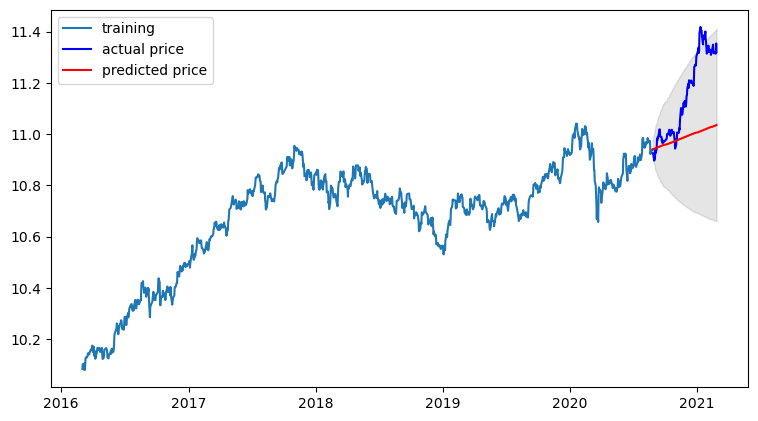

MSE:  218176090.98079973
MAE:  11148.024716059868
RMSE:  14770.78504957674
MAPE: 14.12%


In [354]:
arima_test(samsung_train_data, samsung_test_data, (1, 1, 0))

/home/ssac14/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/ssac14/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1101
Model:                ARIMA(1, 1, 15)   Log Likelihood                2931.247
Method:                       css-mle   S.D. of innovations              0.017
Date:                Mon, 01 Mar 2021   AIC                          -5826.493
Time:                        04:49:27   BIC                          -5736.422
Sample:                             1   HQIC                         -5792.420
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0008      0.000      1.760      0.078   -8.84e-05       0.002
ar.L1.D.Close     -0.9187      0.052    -17.804      0.000      -1.020      -0.818
ma.L1.D.Close      0.9387      0.059

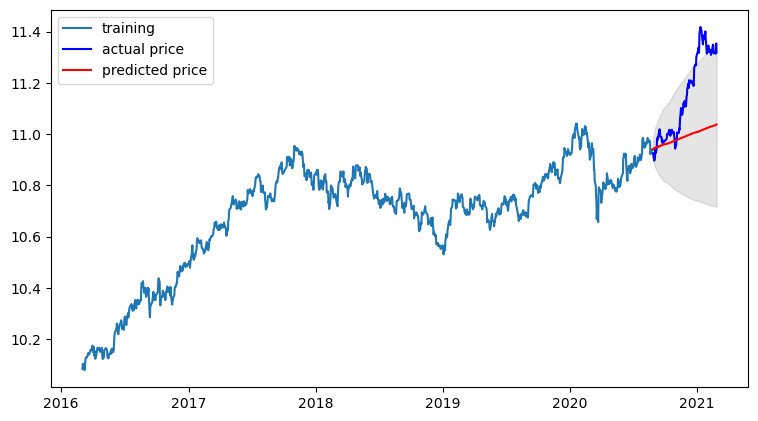

MSE:  215670029.94036666
MAE:  11055.971294829164
RMSE:  14685.708356778936
MAPE: 13.99%


In [378]:
arima_test(samsung_train_data, samsung_test_data, (1, 1, 15))

# 삼성 결과
- 모든 기간의 데이터를 사용하지 않고, 최근 5년간의 데이터만 사용하였다.(18.68% → 14.12%)
- 모수 변경(q : 0 → 15)으로 MAPE가 조금 줄었다.(14.12% → 13.99%)

<br><br><br><br><br>

# 네이버

## 1. 시계열 데이터 준비

In [160]:
# naver - Time Series 생성
naver_dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/035420.KS.csv'
naver_df = pd.read_csv(naver_dataset_filepath, index_col='Date', parse_dates=True)
naver_ts = naver_df['Close']
naver_ts.head()## 2-1. 결측치 처리## 1. 시계열 데이터 준비

Date
2002-10-29    1797.724854
2002-10-30    2012.226074
2002-10-31    1912.125488
2002-11-01    1793.639038
2002-11-04    1703.752808
Name: Close, dtype: float64

## 2. 데이터 전처리
### 2-1. 결측치 처리

In [161]:
print(naver_ts[naver_ts.isna()])
naver_ts = naver_ts.interpolate(method='time')
naver_ts[naver_ts.isna()]

Date
2005-01-03   NaN
2017-11-16   NaN
2017-11-23   NaN
2018-01-02   NaN
2018-11-15   NaN
2019-11-14   NaN
Name: Close, dtype: float64


Series([], Name: Close, dtype: float64)

### 2-2. 로그 변환

In [162]:
naver_ts_log = np.log(naver_ts)

## 3. 시계열 안정성 분석
### 3-1. 정성적 그래프 분석

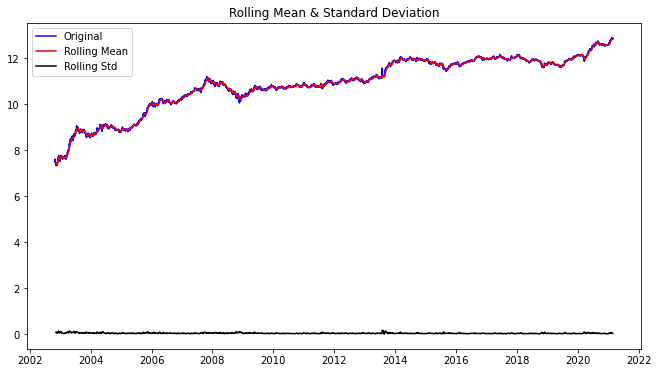

In [163]:
plot_rolling_statistics(naver_ts_log, window=12)

### 3-2. ADF Test

In [164]:
augmented_dickey_fuller_test(naver_ts_log)

Results of Dickey-Fuller Test:
Test Statistic                   -2.847842
p-value                           0.051758
#Lags Used                        9.000000
Number of Observations Used    4573.000000
Critical Value (1%)              -3.431781
Critical Value (5%)              -2.862172
Critical Value (10%)             -2.567107
dtype: float64


### 3-3. 시계열 분해 Time Series Decomposition

Results of Dickey-Fuller Test:
Test Statistic                -1.616408e+01
p-value                        4.434532e-29
#Lags Used                     3.200000e+01
Number of Observations Used    4.520000e+03
Critical Value (1%)           -3.431798e+00
Critical Value (5%)           -2.862180e+00
Critical Value (10%)          -2.567110e+00
dtype: float64


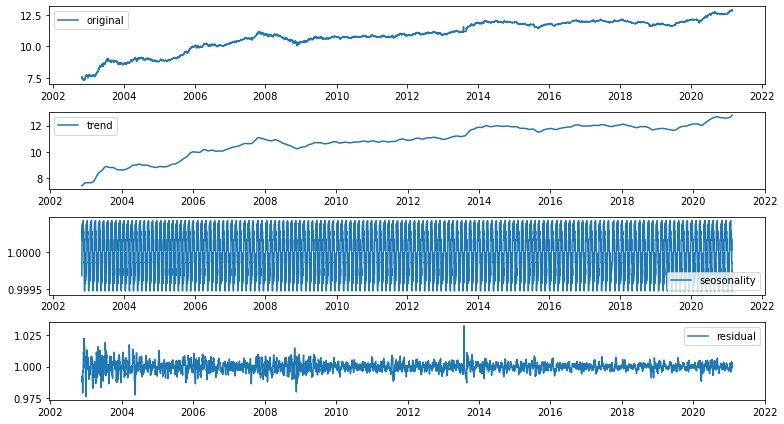

In [165]:
time_series_decomposition(naver_ts_log)

## 4. train, test dataset 생성

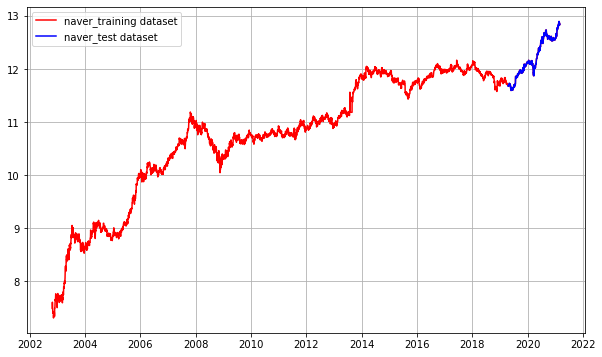

In [166]:
naver_train_data, naver_test_data = naver_ts_log[:int(len(naver_ts_log)*0.9)], naver_ts_log[int(len(naver_ts_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(naver_ts_log, c='r', label='naver_training dataset')
plt.plot(naver_test_data, c='b', label='naver_test dataset')
plt.legend()

## 5. 적정 ARIMA 모수 찾기
- q : ACF를 통해 MA모델의 시차 q를 결정
- p : PACF를 통해 AR 모델의 시차 p를 결정
- d : 차분

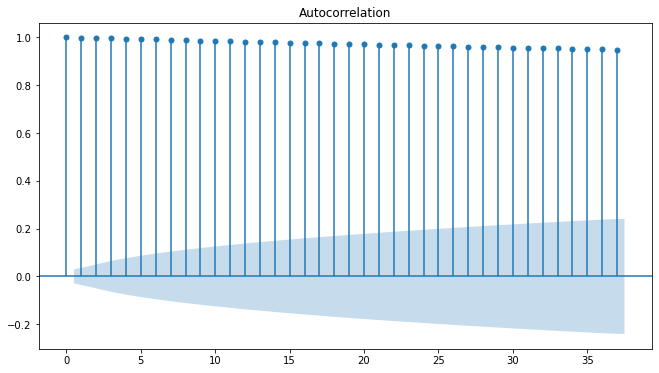

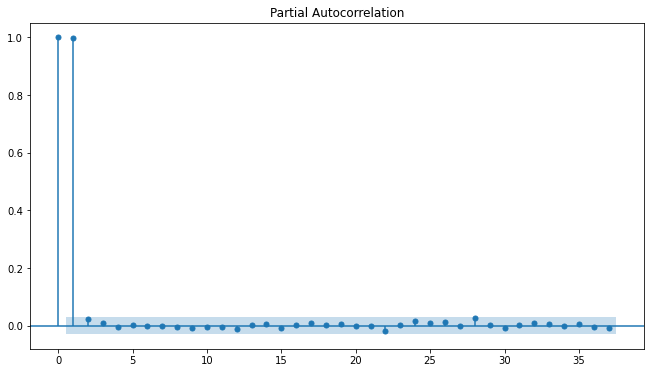

Results of Dickey-Fuller Test:
Test Statistic                  -23.752056
p-value                           0.000000
#Lags Used                        8.000000
Number of Observations Used    4573.000000
Critical Value (1%)              -3.431781
Critical Value (5%)              -2.862172
Critical Value (10%)             -2.567107
dtype: float64


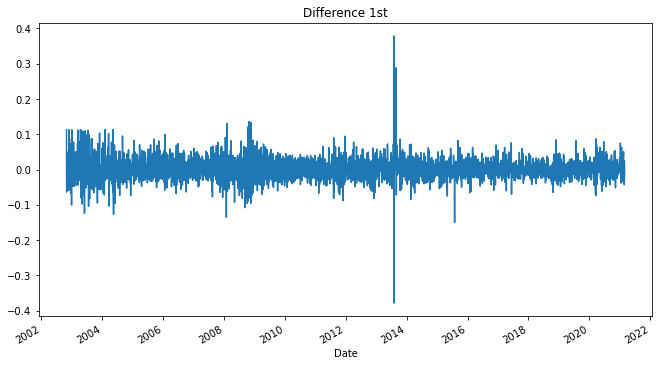

In [167]:
plot_acf(naver_ts_log)
plot_pacf(naver_ts_log)
plt.show()

# 차분 안정성 확인 -> d구하기
naver_diff_1 = naver_ts_log.diff(periods=1).iloc[1:]
naver_diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(naver_diff_1)

- q = 0
- p = 1
- d = 1

## 6. ARIMA 모델 훈련과 테스트

/home/ssac14/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/ssac14/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4123
Model:                 ARIMA(1, 1, 0)   Log Likelihood                8736.960
Method:                       css-mle   S.D. of innovations              0.029
Date:                Mon, 01 Mar 2021   AIC                         -17467.920
Time:                        00:55:28   BIC                         -17448.947
Sample:                             1   HQIC                        -17461.204
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0010      0.000      2.265      0.024       0.000       0.002
ar.L1.D.Close    -0.0105      0.016     -0.675      0.500      -0.041       0.020
                                    Root

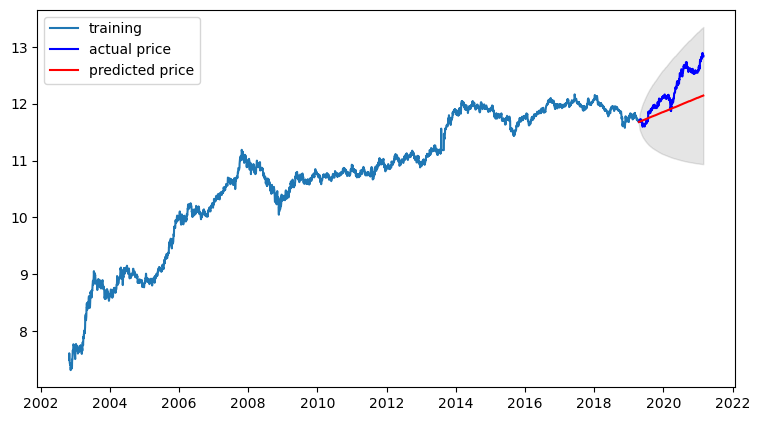

MSE:  7509250121.986464
MAE:  66636.22186135937
RMSE:  86655.92952583489
MAPE: 25.71%


In [173]:
arima_test(naver_train_data, naver_test_data, (1, 1, 0))

<br><br>

# 네이버 2
**모든 기간의 데이터를 사용하지 않고, 최근 5년까지의 데이터만 사용하여 다시 시도해보았다.**

## 1. 시계열 데이터 준비

In [211]:
# naver - Time Series 생성
naver_dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/035420_5y.KS.csv'
naver_df = pd.read_csv(naver_dataset_filepath, index_col='Date', parse_dates=True)
naver_ts = naver_df['Close']
naver_ts.head()## 2-1. 결측치 처리## 1. 시계열 데이터 준비

Date
2016-03-02    121800.0
2016-03-03    122000.0
2016-03-04    122600.0
2016-03-07    119800.0
2016-03-08    120800.0
Name: Close, dtype: float64

## 2. 데이터 전처리
### 2-1. 결측치 처리

In [212]:
print(naver_ts[naver_ts.isna()])
naver_ts = naver_ts.interpolate(method='time')
naver_ts[naver_ts.isna()]

Date
2017-11-16   NaN
2017-11-23   NaN
2018-01-02   NaN
2018-11-15   NaN
2019-11-14   NaN
Name: Close, dtype: float64


Series([], Name: Close, dtype: float64)

### 2-2. 로그 변환

In [213]:
naver_ts_log = np.log(naver_ts)

## 3. 시계열 안정성 분석
### 3-1. 정성적 그래프 분석

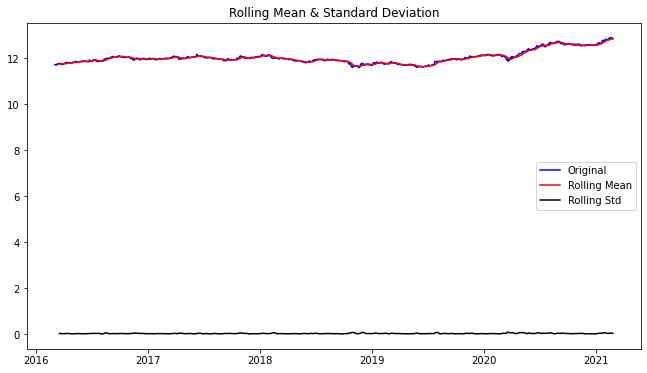

In [214]:
plot_rolling_statistics(naver_ts_log, window=12)

### 3-2. ADF Test

In [215]:
augmented_dickey_fuller_test(naver_ts_log)

Results of Dickey-Fuller Test:
Test Statistic                    0.324317
p-value                           0.978433
#Lags Used                        1.000000
Number of Observations Used    1223.000000
Critical Value (1%)              -3.435708
Critical Value (5%)              -2.863906
Critical Value (10%)             -2.568030
dtype: float64


### 3-3. 시계열 분해 Time Series Decomposition

Results of Dickey-Fuller Test:
Test Statistic                -9.980782e+00
p-value                        2.117583e-17
#Lags Used                     1.700000e+01
Number of Observations Used    1.177000e+03
Critical Value (1%)           -3.435918e+00
Critical Value (5%)           -2.863999e+00
Critical Value (10%)          -2.568079e+00
dtype: float64


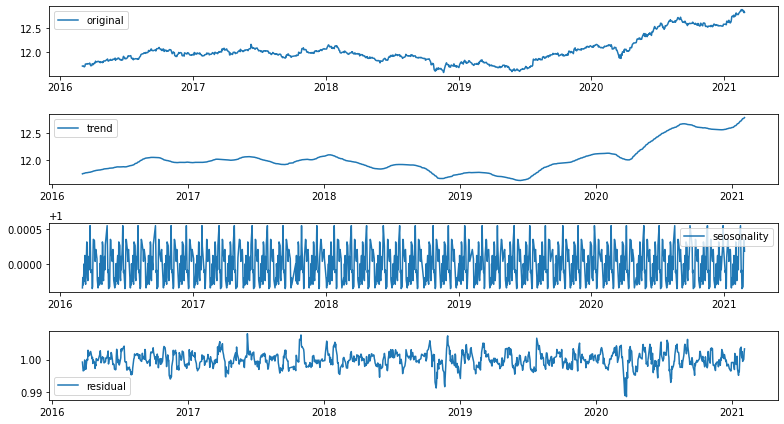

In [216]:
time_series_decomposition(naver_ts_log)

## 4. train, test dataset 생성

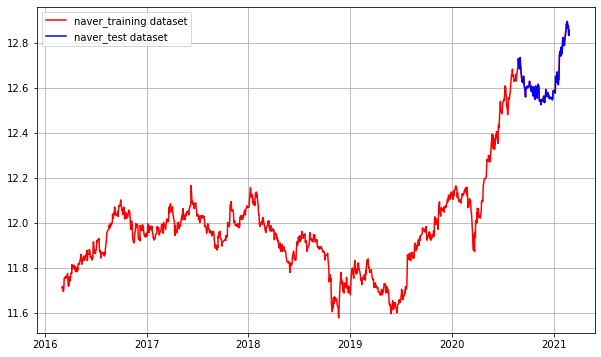

In [217]:
naver_train_data, naver_test_data = naver_ts_log[:int(len(naver_ts_log)*0.9)], naver_ts_log[int(len(naver_ts_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(naver_ts_log, c='r', label='naver_training dataset')
plt.plot(naver_test_data, c='b', label='naver_test dataset')
plt.legend()

## 5. 적정 ARIMA 모수 찾기
- q : ACF를 통해 MA모델의 시차 q를 결정
- p : PACF를 통해 AR 모델의 시차 p를 결정
- d : 차분

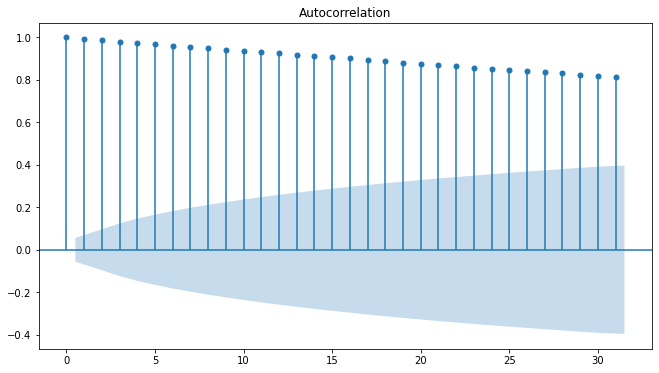

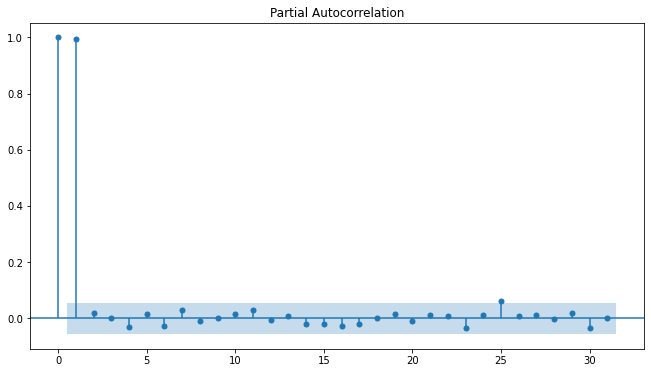

Results of Dickey-Fuller Test:
Test Statistic                  -37.842747
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1223.000000
Critical Value (1%)              -3.435708
Critical Value (5%)              -2.863906
Critical Value (10%)             -2.568030
dtype: float64


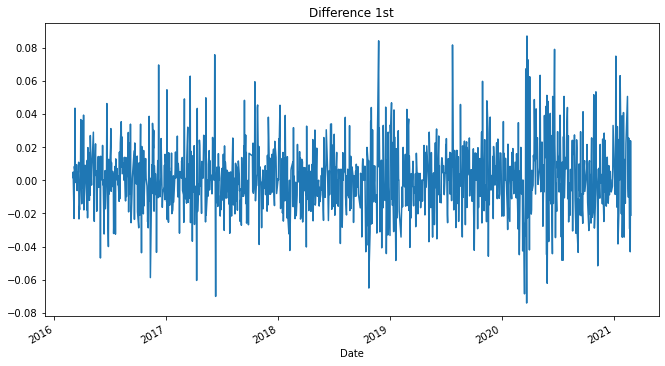

In [218]:
plot_acf(naver_ts_log)
plot_pacf(naver_ts_log)
plt.show()

# 차분 안정성 확인 -> d구하기
naver_diff_1 = naver_ts_log.diff(periods=1).iloc[1:]
naver_diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(naver_diff_1)

- q = 0
- p = 1
- d = 1

## 6. ARIMA 모델 훈련과 테스트

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1101
Model:                 ARIMA(1, 1, 0)   Log Likelihood                2740.811
Method:                       css-mle   S.D. of innovations              0.020
Date:                Mon, 01 Mar 2021   AIC                          -5475.622
Time:                        01:30:06   BIC                          -5460.610
Sample:                             1   HQIC                         -5469.943
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0009      0.001      1.651      0.099      -0.000       0.002
ar.L1.D.Close    -0.0930      0.030     -3.098      0.002      -0.152      -0.034
                                    Root

/home/ssac14/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/ssac14/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


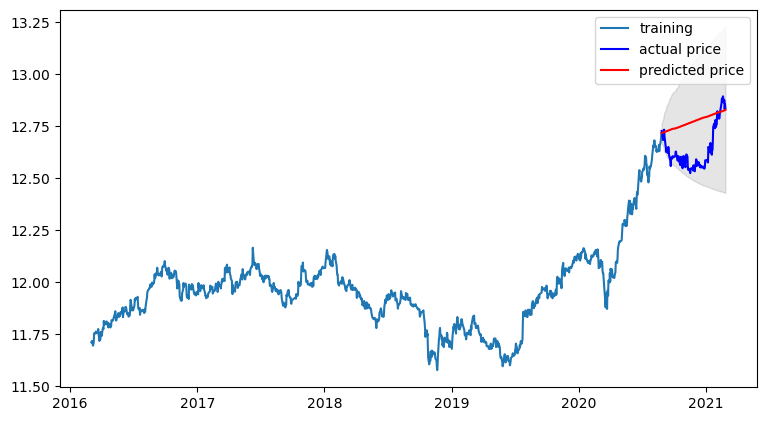

MSE:  2653200763.417658
MAE:  45841.066127853985
RMSE:  51509.22988569774
MAPE: 15.58%


In [248]:
arima_test(naver_train_data, naver_test_data, (1, 1, 0))

# 네이버 3

/home/ssac14/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/ssac14/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/ssac14/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/ssac14/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWar

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1101
Model:               ARIMA(15, 1, 15)   Log Likelihood                2765.798
Method:                       css-mle   S.D. of innovations              0.020
Date:                Mon, 01 Mar 2021   AIC                          -5467.596
Time:                        03:15:06   BIC                          -5307.469
Sample:                             1   HQIC                         -5407.022
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0009      0.001      1.713      0.087      -0.000       0.002
ar.L1.D.Close      0.4326      0.186      2.324      0.020       0.068       0.797
ar.L2.D.Close      0.1683      0.210

/home/ssac14/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:1521: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


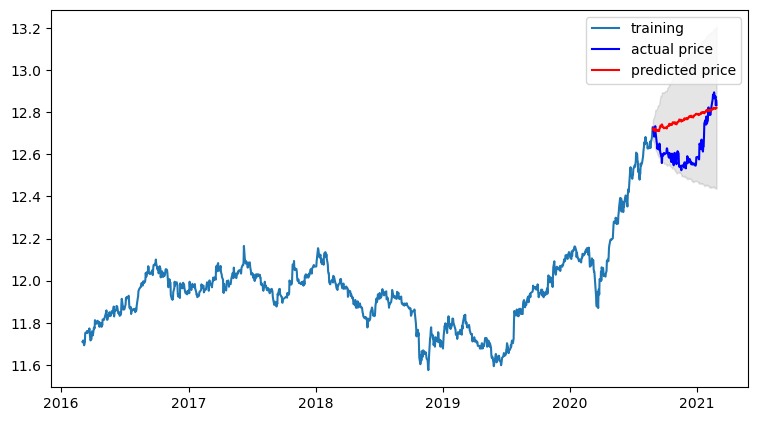

MSE:  2459126349.416532
MAE:  43918.7002139948
RMSE:  49589.57904052556
MAPE: 14.92%


In [272]:
arima_test(naver_train_data, naver_test_data, (15, 1, 15))

/home/ssac14/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                 1102
Model:                     ARMA(1, 0)   Log Likelihood                2734.637
Method:                       css-mle   S.D. of innovations              0.020
Date:                Mon, 01 Mar 2021   AIC                          -5463.274
Time:                        03:19:51   BIC                          -5448.259
Sample:                             0   HQIC                         -5457.594
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.1005      0.286     42.314      0.000      11.540      12.661
ar.L1.Close     0.9985      0.002    605.338      0.000       0.995       1.002
                                    Roots       

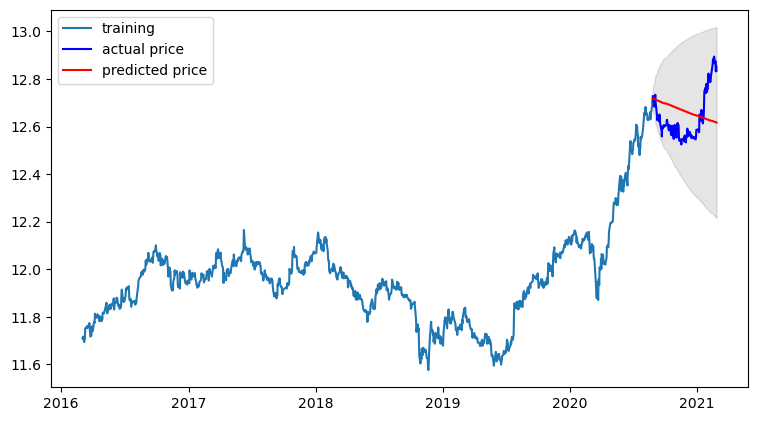

MSE:  1474491327.1615014
MAE:  32683.5042854651
RMSE:  38399.10581200429
MAPE: 10.32%


In [280]:
arima_test(naver_train_data, naver_test_data, (1, 0, 0))

/home/ssac14/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                 1102
Model:                    ARMA(30, 0)   Log Likelihood                2755.184
Method:                       css-mle   S.D. of innovations              0.020
Date:                Mon, 01 Mar 2021   AIC                          -5446.369
Time:                        03:48:10   BIC                          -5286.213
Sample:                             0   HQIC                         -5385.786
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           12.0792      0.251     48.136      0.000      11.587      12.571
ar.L1.Close      0.9160      0.030     30.454      0.000       0.857       0.975
ar.L2.Close      0.1376      0.041      3.38

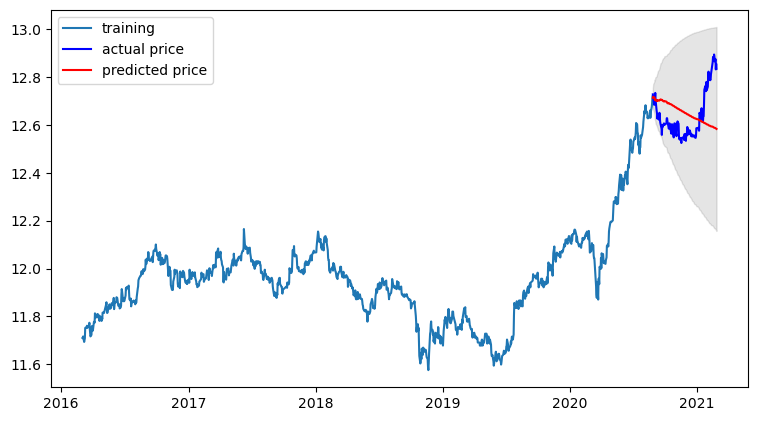

MSE:  1618636203.514225
MAE:  32812.45810692258
RMSE:  40232.27812980797
MAPE: 10.22%


In [298]:
arima_test(naver_train_data, naver_test_data, (30, 0, 0))

# 네이버 결과
- 모든 기간의 데이터를 사용했을 때보다 최근 5년간의 데이터만 사용했을 때 MAPE를 약 10% 가량 낮출 수 있었다. (25.71% → 15.58%)
- p와 q를 같은 값으로 넣어주었더니 예측모양이 지그재그형태를 띄는 것을 볼 수 있었다. 주식이 일정한 균형수준을 유지하는 것과 최근 패턴을 따라 움직이려는 부분이 서로 대비되는 형태를 띄어서 그런 것이 아닐까 추측해본다. (15.58% → 14.92%) 
- 차분을 1에서 0으로 낮췄더니 MAPE가 약 5%가량 낮아졌다.(14.92% → 10.32%)

<br><br><br><br><br>

# 카카오

## 1. 시계열 데이터 준비
- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
- date와 close(종가)컬럼만 사용

In [313]:
# kakao - Time Series 생성
kakao_dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/035720.KS.csv'
kakao_df = pd.read_csv(kakao_dataset_filepath, index_col='Date', parse_dates=True)
kakao_ts = kakao_df['Close']
kakao_ts.head()

Date
2000-02-11    273000.0
2000-02-14    247000.0
2000-02-15    217500.0
2000-02-16    243500.0
2000-02-17    243500.0
Name: Close, dtype: float64

## 2. 데이터 전처리
### 2-1. 결측치 처리

In [314]:
print(kakao_ts[kakao_ts.isna()])
kakao_ts = kakao_ts.interpolate(method='time')
kakao_ts[kakao_ts.isna()]

Date
2005-01-03   NaN
2017-11-16   NaN
2017-11-23   NaN
2018-01-02   NaN
2018-11-15   NaN
2019-11-14   NaN
Name: Close, dtype: float64


Series([], Name: Close, dtype: float64)

### 2-2. 로그 변환

In [315]:
kakao_ts_log = np.log(kakao_ts)

## 3. 시계열 안정성 분석
### 3-1. 정성적 그래프 분석

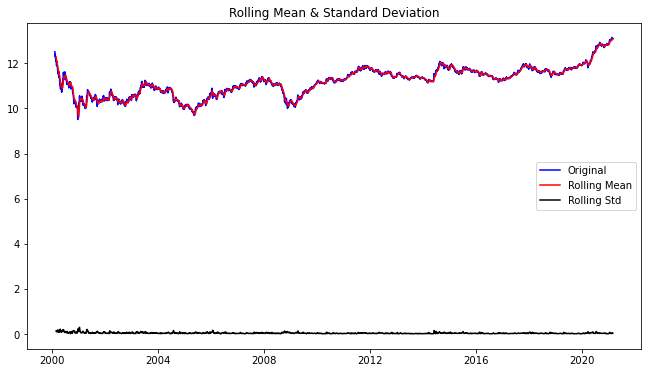

In [316]:
plot_rolling_statistics(kakao_ts_log, window=12)

### 3-2. ADF Test

In [317]:
augmented_dickey_fuller_test(kakao_ts_log)

Results of Dickey-Fuller Test:
Test Statistic                   -1.222926
p-value                           0.663657
#Lags Used                        5.000000
Number of Observations Used    5284.000000
Critical Value (1%)              -3.431588
Critical Value (5%)              -2.862087
Critical Value (10%)             -2.567061
dtype: float64


### 3-3. 시계열 분해 Time Series Decomposition

Results of Dickey-Fuller Test:
Test Statistic                -1.790562e+01
p-value                        2.942350e-30
#Lags Used                     3.300000e+01
Number of Observations Used    5.226000e+03
Critical Value (1%)           -3.431602e+00
Critical Value (5%)           -2.862093e+00
Critical Value (10%)          -2.567064e+00
dtype: float64


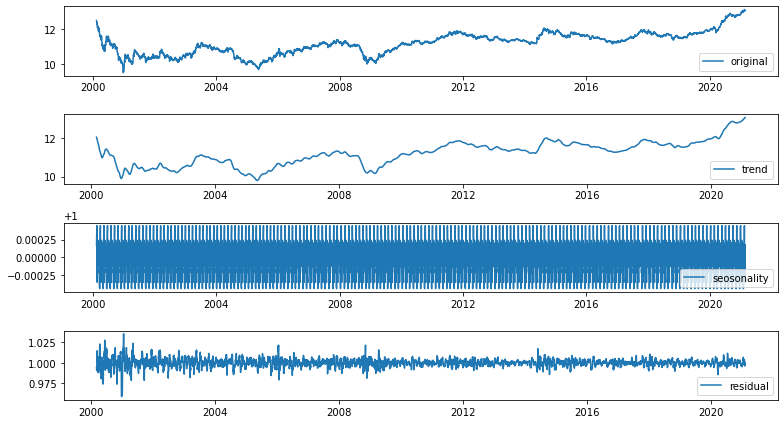

In [318]:
time_series_decomposition(kakao_ts_log)

## 4. train, test dataset 생성

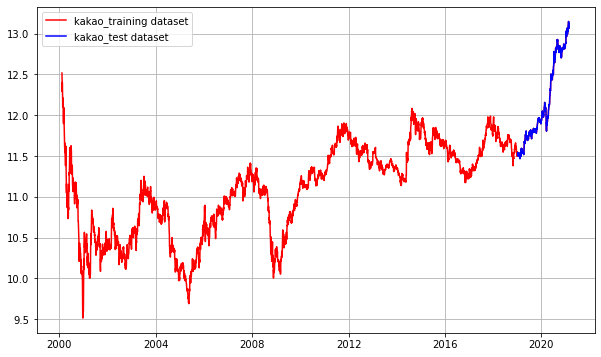

In [319]:
kakao_train_data, kakao_test_data = kakao_ts_log[:int(len(kakao_ts_log)*0.9)], kakao_ts_log[int(len(kakao_ts_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(kakao_ts_log, c='r', label='kakao_training dataset')
plt.plot(kakao_test_data, c='b', label='kakao_test dataset')
plt.legend()

## 5. 적정 ARIMA 모수 찾기
- q : ACF를 통해 MA모델의 시차 q를 결정
- p : PACF를 통해 AR 모델의 시차 p를 결정
- d : 차분

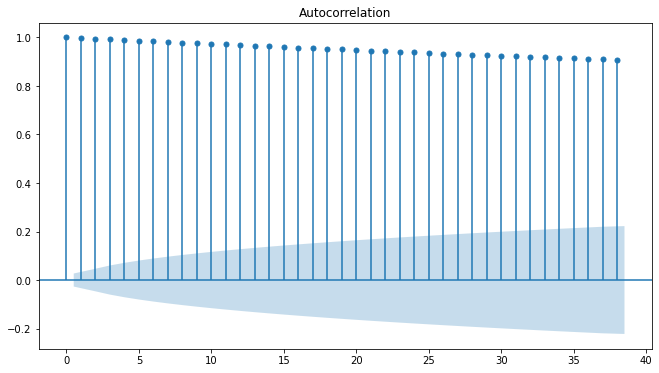

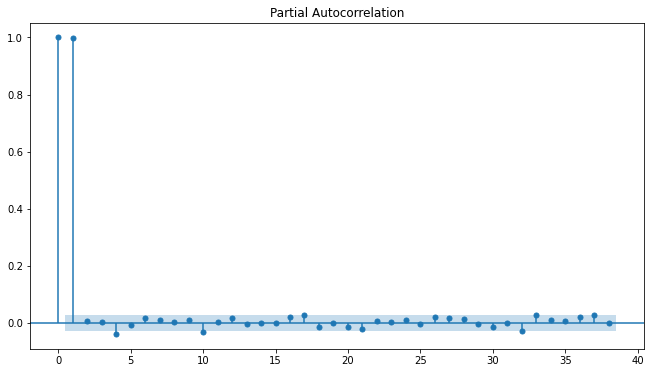

In [320]:
plot_acf(kakao_ts_log)
plot_pacf(kakao_ts_log)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -32.350735
p-value                           0.000000
#Lags Used                        4.000000
Number of Observations Used    5284.000000
Critical Value (1%)              -3.431588
Critical Value (5%)              -2.862087
Critical Value (10%)             -2.567061
dtype: float64


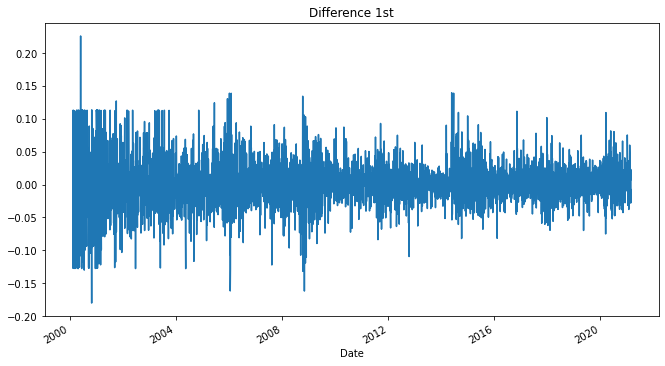

In [321]:
# 차분 안정성 확인 -> d구하기
kakao_diff_1 = kakao_ts_log.diff(periods=1).iloc[1:]
kakao_diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(kakao_diff_1)

- q = 0
- p = 1
- d = 1

## 6. ARIMA 모델 훈련과 테스트

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4760
Model:                 ARIMA(1, 1, 0)   Log Likelihood                9365.180
Method:                       css-mle   S.D. of innovations              0.034
Date:                Mon, 01 Mar 2021   AIC                         -18724.360
Time:                        04:00:33   BIC                         -18704.956
Sample:                             1   HQIC                        -18717.543
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0002      0.000     -0.413      0.680      -0.001       0.001
ar.L1.D.Close     0.0079      0.015      0.542      0.588      -0.021       0.036
                                    Root

/home/ssac14/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/ssac14/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


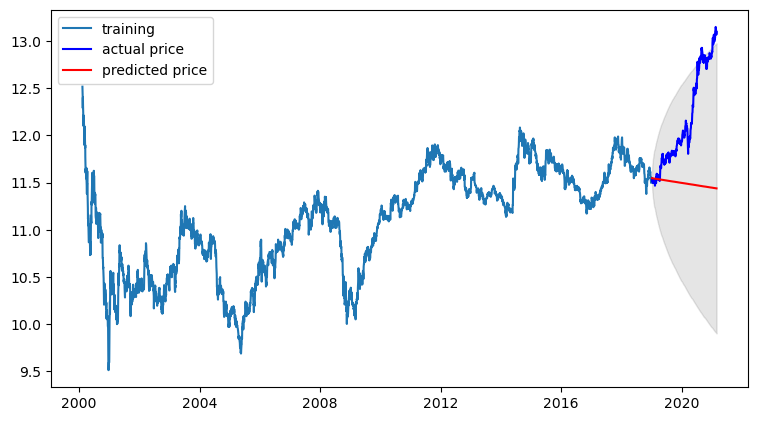

MSE:  29607280458.96069
MAE:  123471.22384782482
RMSE:  172067.66244405336
MAPE: 42.84%


In [322]:
arima_test(kakao_train_data, kakao_test_data, (1, 1, 0))

# 카카오 2

## 1. 시계열 데이터 준비
- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
- date와 close(종가)컬럼만 사용

In [326]:
# kakao - Time Series 생성
kakao_dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/035720_5y.KS.csv'
kakao_df = pd.read_csv(kakao_dataset_filepath, index_col='Date', parse_dates=True)
kakao_ts = kakao_df['Close']
kakao_ts.head()

Date
2016-03-02     97400.0
2016-03-03    101500.0
2016-03-04    103800.0
2016-03-07    105900.0
2016-03-08    106200.0
Name: Close, dtype: float64

## 2. 데이터 전처리
### 2-1. 결측치 처리

In [327]:
print(kakao_ts[kakao_ts.isna()])
kakao_ts = kakao_ts.interpolate(method='time')
kakao_ts[kakao_ts.isna()]

Date
2017-11-16   NaN
2017-11-23   NaN
2018-01-02   NaN
2018-11-15   NaN
2019-11-14   NaN
Name: Close, dtype: float64


Series([], Name: Close, dtype: float64)

### 2-2. 로그 변환

In [328]:
kakao_ts_log = np.log(kakao_ts)

## 3. 시계열 안정성 분석
### 3-1. 정성적 그래프 분석

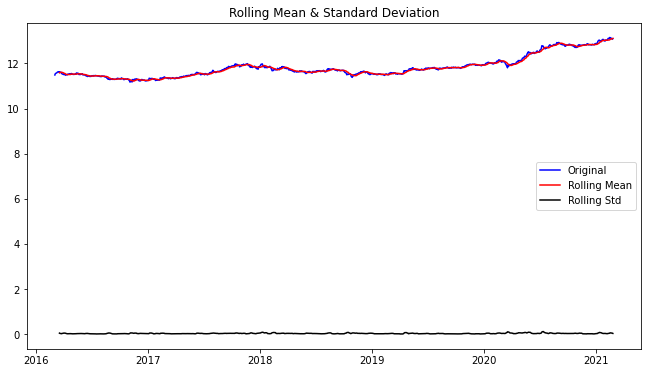

In [329]:
plot_rolling_statistics(kakao_ts_log, window=12)

### 3-2. ADF Test

In [330]:
augmented_dickey_fuller_test(kakao_ts_log)

Results of Dickey-Fuller Test:
Test Statistic                    1.423537
p-value                           0.997218
#Lags Used                        6.000000
Number of Observations Used    1218.000000
Critical Value (1%)              -3.435730
Critical Value (5%)              -2.863916
Critical Value (10%)             -2.568035
dtype: float64


### 3-3. 시계열 분해 Time Series Decomposition

Results of Dickey-Fuller Test:
Test Statistic                -1.064975e+01
p-value                        4.694474e-19
#Lags Used                     2.300000e+01
Number of Observations Used    1.171000e+03
Critical Value (1%)           -3.435947e+00
Critical Value (5%)           -2.864011e+00
Critical Value (10%)          -2.568086e+00
dtype: float64


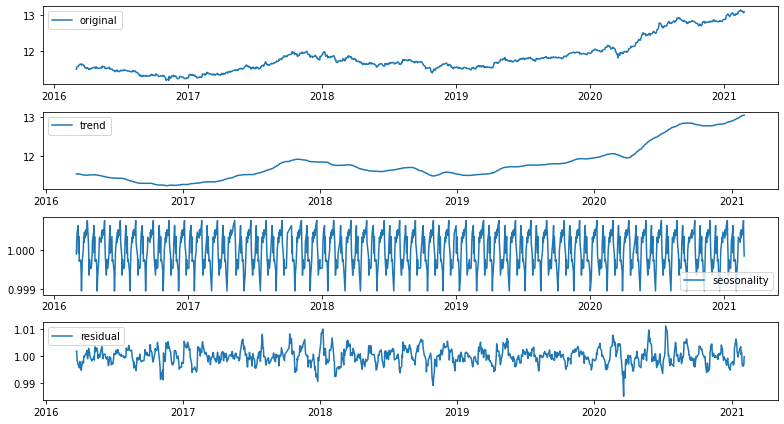

In [331]:
time_series_decomposition(kakao_ts_log)

## 4. train, test dataset 생성

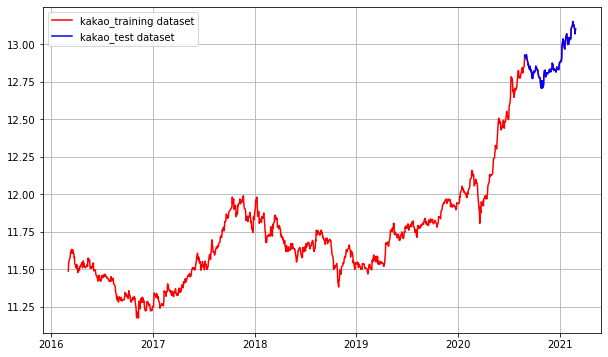

In [332]:
kakao_train_data, kakao_test_data = kakao_ts_log[:int(len(kakao_ts_log)*0.9)], kakao_ts_log[int(len(kakao_ts_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(kakao_ts_log, c='r', label='kakao_training dataset')
plt.plot(kakao_test_data, c='b', label='kakao_test dataset')
plt.legend()

## 5. 적정 ARIMA 모수 찾기
- q : ACF를 통해 MA모델의 시차 q를 결정
- p : PACF를 통해 AR 모델의 시차 p를 결정
- d : 차분

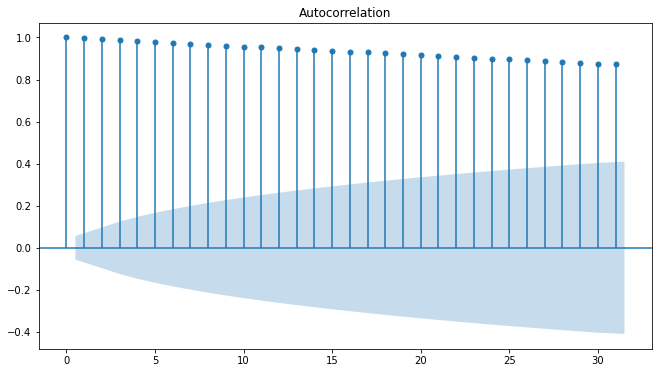

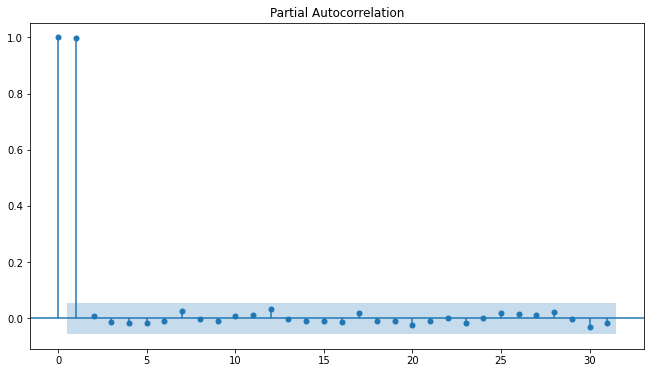

In [333]:
plot_acf(kakao_ts_log)
plot_pacf(kakao_ts_log)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.518001e+01
p-value                        6.216613e-28
#Lags Used                     5.000000e+00
Number of Observations Used    1.218000e+03
Critical Value (1%)           -3.435730e+00
Critical Value (5%)           -2.863916e+00
Critical Value (10%)          -2.568035e+00
dtype: float64


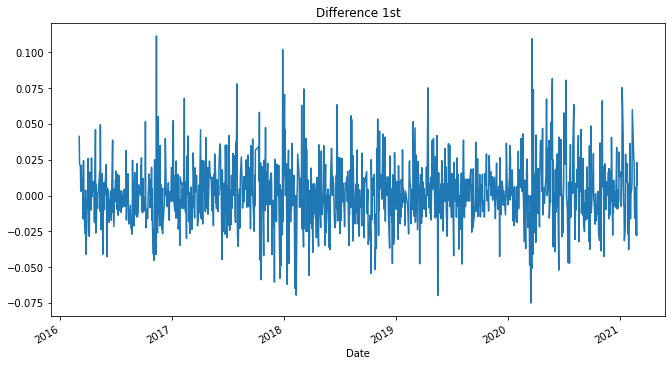

In [334]:
# 차분 안정성 확인 -> d구하기
kakao_diff_1 = kakao_ts_log.diff(periods=1).iloc[1:]
kakao_diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(kakao_diff_1)

- q = 0
- p = 1
- d = 1

## 6. ARIMA 모델 훈련과 테스트

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1101
Model:                 ARIMA(1, 1, 0)   Log Likelihood                2640.986
Method:                       css-mle   S.D. of innovations              0.022
Date:                Mon, 01 Mar 2021   AIC                          -5275.972
Time:                        04:02:31   BIC                          -5260.960
Sample:                             1   HQIC                         -5270.293
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0013      0.001      1.931      0.054   -1.91e-05       0.003
ar.L1.D.Close    -0.0119      0.030     -0.394      0.694      -0.071       0.047
                                    Root

/home/ssac14/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/ssac14/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


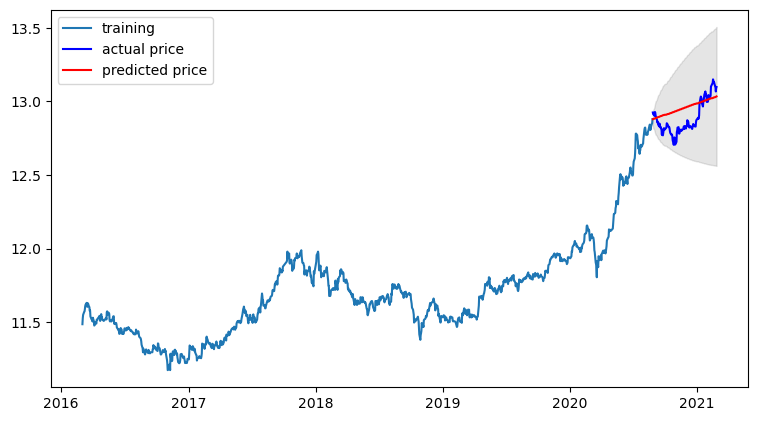

MSE:  1957099298.887518
MAE:  38636.887713221295
RMSE:  44239.11503282494
MAPE: 10.22%


In [335]:
arima_test(kakao_train_data, kakao_test_data, (1, 1, 0))

# 카카오 결과

- 데이터의 기간을 전체가 아닌 최근 5년의 데이터로 학습을 시키니 MAPE가 무려 32%가 줄어들었다. (42.84% → 10.22%)

<br><br><br><br>

# 회고
### 이번 프로젝트에서 **어려웠던 점**
모수에 대한 이해도가 낮은 상태에서 진행하려니 MAPE를 낮추기 어려웠던 것 같고, 주식의 다양한 변수에 대해서는 적용이 되어 있지 않으니, 더욱 더 예측하기 어려웠던 것 같다.


### 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점** 
`p*q=0`인 값들을 통상적으로 사용한다고 배웠는데, 실제로 p=15, q=15 등 같은 값을 사용했을 때, 예측값이 지그재그 형태를 띄며 예측하는 것을 보았다. 대부분의 시계열데이터가 AR과 MA 중 하나의 경향만을 강하게 띠기 때문에 이런 그래프가 나오게 된 것일까?


### 루브릭 평가 지표를 맞추기 위해 시도한 것들
- 데이터의 기준 기간 변경(시계열데이터인만큼 최근의 데이터의 영향을 더 많이 받기 위해 기간을 모든 기간이 아닌 최근 5년이내의 데이터로 처리해주었다.)
- 모수 변경


### 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**.
3개의 주식에 대해 예측했지만 MAPE가 10% 미만이 되지 못했다.  
모수 p, q를 각각 30까지도 높여보고, 혹시 몰라 다양한 조합을 해보았지만 모수의 수정만으로 크게 개선되지 않았다. 

- 주가의 특이치에 대한 처리 부족


### 자기 다짐
기존에 시계열데이터에 대해 다양한 모델을 적용해봤던 걸로 기억한다. 캐글을 했을 때도 LSTM이나 XGB 등을 사용했었는데, 주식을 예측하는데에도 써보면 어떨까 생각해보았고, 각 모델에 대한 차이가 무엇인지 한번 생각해볼 필요가 있는 것 같다. 또한 특이치에 대해 어떻게 처리해줘야하는지 다른 사람들이 했던 것들을 보면서 공부해봐야겠다. 그리고 기존에 시계열데이터의 이상치에 대해 공부했던 것 다시 복습할 필요성을 느낀다.